In [1]:
import warnings, pickle, os
warnings.filterwarnings("ignore")
os.chdir("..")

import torch, random
import torch.nn as nn

import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sklearn.preprocessing import StandardScaler
from src.data.sm_dataloader import *
from src.data.ap_dataloader import *
from src.preprocessing.sm_label_transformer import *
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

In [5]:
from src.animations.insert_animation import *
from src.models import config
from src.preprocessing.sm_label_transformer import *
from src.models.ordinal_classifier_fnn import *
from src.models.animation_prediction import AnimationPredictor
from src.models.train_animation_predictor import *

In [6]:
train_dataset = DatasetAP(path='data/path_selector', train=True)
test_dataset = DatasetAP(path='data/path_selector', train=False)

In [7]:
# NEW: implemented scaling for training to work
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, :])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [8]:
train_dataset.X[0]

tensor([ 1.3303,  0.2945, -0.3531, -0.2461, -0.7445,  1.7896,  0.4351, -1.2801,
         3.7392, -1.0522,  0.6150, -1.1097,  0.2561,  1.4655,  0.6084,  0.1744,
        -0.3207, -1.3953,  0.1337,  0.0670, -0.0996,  1.1757,  0.6242,  1.0308,
         0.5682, -0.5961])

In [9]:
test_dataset.X.shape

torch.Size([441, 26])

### Animation predictor model

In [10]:
animation_predictor = AnimationPredictor()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
animation_predictor.to(device)

AnimationPredictor(
  (hidden_1): Linear(in_features=26, out_features=15, bias=True)
  (hidden_2): Linear(in_features=32, out_features=20, bias=True)
  (out_1): Linear(in_features=15, out_features=6, bias=True)
  (out_2): Linear(in_features=20, out_features=6, bias=True)
)

In [13]:
animations = animation_predictor(test_dataset.X[:5])

In [14]:
learning_rate = 0.0005

In [15]:
# learning rate may be increased for faster convergence of training
optimizer = torch.optim.Adam(animation_predictor.parameters(), lr=learning_rate)

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# number of epochs may be decreased if learninig rate gets increased
n_epochs = 30

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

In [18]:
%%time
sm = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38, 28])
sm.load_state_dict(torch.load('models/sm_fnn.pth'))
for p in sm.parameters():
    p.requires_grad = False
sm.eval()

for it in range(n_epochs):
    train_loss, test_loss = list(), list()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = create_animation_vector(animation_predictor.forward(inputs)) # output: animation vector
        sm_logits = sm(outputs) # output: network logits (4 nodes per example)
        sm_probas = torch.sigmoid(sm_logits) # output: probabilities between 0 and 1 (4 nodes per example, DO NOT necessarily sum up to 1)
        loss = -(sm_probas).mean() # just use mean (sum would also work) of probabilities as evaluation measure for animation (the higher, the better)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # store loss
        train_loss.append(loss.item())
    
    # get averaged train loss
    train_loss = np.mean(train_loss)
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # forward pass
        outputs = create_animation_vector(animation_predictor.forward(inputs))
        sm_logits = sm(outputs)
        sm_probas = torch.sigmoid(sm_logits)
        loss = -(sm_probas).mean()
        
        # store loss
        test_loss.append(loss.item())
    
    # get averaged test loss
    test_loss = np.mean(test_loss)
    
    # save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    print(f'Epoch: {it + 1}/{n_epochs}::Train loss={1-abs(train_loss):.4f}, test loss={1-abs(test_loss):.4f}')

Epoch: 1/30::Train loss=0.7000, test loss=0.7161
Epoch: 2/30::Train loss=0.6992, test loss=0.7249
Epoch: 3/30::Train loss=0.7028, test loss=0.7257
Epoch: 4/30::Train loss=0.6993, test loss=0.7198
Epoch: 5/30::Train loss=0.6864, test loss=0.7045
Epoch: 6/30::Train loss=0.6700, test loss=0.6991
Epoch: 7/30::Train loss=0.6613, test loss=0.6959
Epoch: 8/30::Train loss=0.6507, test loss=0.6830
Epoch: 9/30::Train loss=0.6412, test loss=0.6745
Epoch: 10/30::Train loss=0.6286, test loss=0.6612
Epoch: 11/30::Train loss=0.6192, test loss=0.6466
Epoch: 12/30::Train loss=0.6104, test loss=0.6434
Epoch: 13/30::Train loss=0.6049, test loss=0.6333
Epoch: 14/30::Train loss=0.6010, test loss=0.6221
Epoch: 15/30::Train loss=0.5974, test loss=0.6212
Epoch: 16/30::Train loss=0.5926, test loss=0.6180
Epoch: 17/30::Train loss=0.5896, test loss=0.6164
Epoch: 18/30::Train loss=0.5862, test loss=0.6147
Epoch: 19/30::Train loss=0.5832, test loss=0.6111
Epoch: 20/30::Train loss=0.5803, test loss=0.6030
Epoch: 21

<AxesSubplot:xlabel='epoch'>

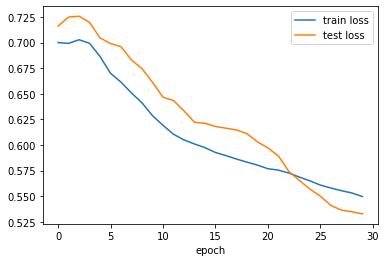

In [20]:
i = 30
loss = pd.DataFrame({'epoch': list(range(i)), 'train loss': [1-abs(l) for l in train_losses][:i], 'test loss': [1-abs(l) for l in test_losses][:i]})
loss.plot(x='epoch', y=['train loss', 'test loss'], kind="line")

<AxesSubplot:xlabel='epoch'>

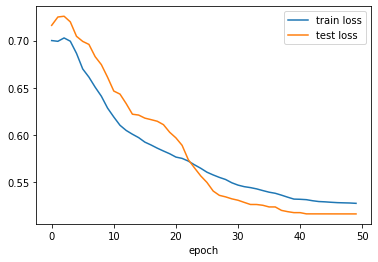

In [21]:
# To reproduce this graph, please set n_epochs=50 in training
i = 50
loss = pd.DataFrame({'epoch': list(range(i)), 'train loss': [1-abs(l) for l in train_losses][:i], 'test loss': [1-abs(l) for l in test_losses][:i]})
loss.plot(x='epoch', y=['train loss', 'test loss'], kind="line")

In [22]:
torch.save(animation_predictor, f'models/ap_best_model.pkl')
torch.save(animation_predictor.state_dict(), f'models/ap_best_model_state_dict.pth')

## Insertion of animations

In [22]:
animation_predictions = create_animation_vector(animation_predictor(test.X))

In [23]:
test_data = pd.read_csv('data/path_selector/selected_paths_test.csv')

In [24]:
%%time
logos = test_data['filename'].unique()
for i, logo in enumerate(logos):
    if i % 20 == 0:
        print(f'Animate logo {i}/{len(logos)}')
    preds = animation_predictions[test_data[test_data['filename'] == logo].index.tolist()].detach().numpy()
    animation_ids = test_data[test_data['filename'] == logo]['animation_id'].tolist()
    create_animated_svg(f'data/svgs_preprocessed_expanded/{logo}.svg', animation_ids, preds)

Animate logo 0/86
Animate logo 20/86
Animate logo 40/86
Animate logo 60/86
Animate logo 80/86
Wall time: 2min 15s
